# Milestone 2 - Data Collection and description

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Table of content
[1. Loading](#Loading)<br>

[2. Data exploration and cleaning](#cleaning) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.A Raw Crops](#cleaning-crops) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.B Raw Trades](#cleaning-trades) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.C Raw Trades 2017](#cleaning-trades-2017) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.D Missing Values](#cleaning-missing-values) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Crops](#cleaning-missing-values-crops) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Trades](#cleaning-missing-values-trades) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Trades 2017](#cleaning-missing-values-trades-2017) <br>

[3. Merge Dataframes](#merge) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.A Trades and Trades 2017](#merge-trades) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.B Item Labelling](#merge-items) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Introduction to the problem](#merge-items-intro) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Try first word as key word](#extraction1) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Implementation with stemmer and fixes](#extraction2) <br>

[4. Group by countries](#group-countries) <br>

[5. Group by crops](#group-crops) <br>

[6. Import-export Dataframe](#import) <br>

[7. Plots](#plots) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[7.A First Example : Biggest importers and exporters](#plots1) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[7.B Second Example : Net Exported quantity and profit in Europe](#plots2) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[7.C Third Example : Time Series for Net Exported quantity and profit in Europe](#plots3) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[7.D Fourth Example : Most Exported Crop in Africa](#plots4) <br>

[8. Conclusion and next steps](#ccl) <br>

[9. Teaser](#teaser) <br>



<a id='Loading'></a>
## 1. Loading

Reference of dataset : http://www.fao.org/faostat/en/#data

We choose to work with three tables : 
- Crops (from production) [download here](http://fenixservices.fao.org/faostat/static/bulkdownloads/Production_Crops_E_All_Data_(Normalized).zip)
- Crops and livestock products (from trades) for all years normalized [download here](http://fenixservices.fao.org/faostat/static/bulkdownloads/Trade_Crops_Livestock_E_All_Data_(Normalized).zip) 
- Crops and livestock products (from trades) for the year 2017 normalized

**Description of the datasets :**

The Crops dataframe contains all the crops and groups of crops produced for each country during a period between 1961 and 2017. For each country, each year and a specific crop, we can see three different type of values : 
   - The production [tonnes]
   - The yield [hg/ha]
   - The surface area [ha]

Each Item (a crop basically) has an associated ID and the same for every countries. The file has also a `Flag` column which describes the origin of the data. 

Different types of `Flag` : 
- 'M' : Missing 
- 'A' : Aggregate, may include official, semi-official, estimated or calculated data
- 'F' : FAO estimate
- 'Im' : FAO data based on imputation methodology - 
- 'Fc' : Calculated data

Regarding the `Flag`, the data may also come from an official source and the field is left empty in the .csv file so when it is uploaded with pandas those will `np.nan`

The second file focuses on the trading of Crops but also livestocks products. The file is downloaded on the same website. We have the following element (type of data) for each item (crops or products) for each country and each year : 
   - The import value [1000 \$]
   - The import quantity [tonnes]
   - The export value [1000 \$]
   - The export quantity [tonnes]
   
  
We included the last file from the FAOSTAT because when we downloaded the file "Crops and livestock products" the last year with records was the year 2016. So, to be consistent with the crops production file which stop in 2017 we decided to add this year as well in the trades

In [2]:
raw_crops = pd.read_csv('data/crops_production.csv',encoding = "ISO-8859-1")
raw_trade = pd.read_csv('data/crops_trades.csv',encoding = "ISO-8859-1")
raw_trade_2017 = pd.read_csv('data/crops_trades_2017.csv')

For consistency, we put all columns titles to lower case and use underscores. We will stick to this for the whole notebook.

In [3]:
raw_crops.columns = map(lambda name : name.lower().replace(' ', '_'), raw_crops.columns) #Column names to lower case
raw_trade.columns = map(lambda name : name.lower().replace(' ', '_'), raw_trade.columns) #Column names to lower case
raw_trade_2017.columns = map(lambda name : name.lower().replace(' ', '_'), raw_trade_2017.columns) #Column names to lower case

In [4]:
print(raw_crops.shape)
raw_crops.head()

(2425275, 11)


,area_code,area,item_code,item,element_code,element,year_code,year,unit,value,flag
0,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1975,1975,ha,0.0,F
1,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1976,1976,ha,5900.0,F
2,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1977,1977,ha,6000.0,F
3,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1978,1978,ha,6000.0,F
4,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1979,1979,ha,6000.0,F


In [5]:
print(raw_trade.shape)
raw_trade.head()

(15386177, 11)


,area_code,area,item_code,item,element_code,element,year_code,year,unit,value,flag
0,2,Afghanistan,231,Almonds shelled,5610,Import Quantity,2014,2014,tonnes,167.0,R
1,2,Afghanistan,231,Almonds shelled,5610,Import Quantity,2015,2015,tonnes,181.0,R
2,2,Afghanistan,231,Almonds shelled,5610,Import Quantity,2016,2016,tonnes,845.0,R
3,2,Afghanistan,231,Almonds shelled,5622,Import Value,2014,2014,1000 US$,1116.0,R
4,2,Afghanistan,231,Almonds shelled,5622,Import Value,2015,2015,1000 US$,1377.0,R


In [6]:
print(raw_trade_2017.shape)
raw_trade_2017.head()

(175158, 14)


,domain_code,domain,area_code,area,element_code,element,item_code,item,year_code,year,unit,value,flag,flag_description
0,TP,Crops and livestock products,2,Afghanistan,5610,Import Quantity,231,Almonds shelled,2017,2017,tonnes,102.0,R,Estimated data using trading partners database
1,TP,Crops and livestock products,2,Afghanistan,5622,Import Value,231,Almonds shelled,2017,2017,1000 US$,758.0,R,Estimated data using trading partners database
2,TP,Crops and livestock products,2,Afghanistan,5910,Export Quantity,231,Almonds shelled,2017,2017,tonnes,3335.0,NaN,Official data
3,TP,Crops and livestock products,2,Afghanistan,5922,Export Value,231,Almonds shelled,2017,2017,1000 US$,23248.0,NaN,Official data
4,TP,Crops and livestock products,2,Afghanistan,5610,Import Quantity,221,"Almonds, with shell",2017,2017,tonnes,41.0,R,Estimated data using trading partners database


<a id='cleaning'></a>
## 2. Data exploration and cleaning

<a id='cleaning-crops'></a>
### 2.A. Raw Crops

In [7]:
raw_crops.dtypes

area_code         int64
area             object
item_code         int64
item             object
element_code      int64
element          object
year_code         int64
year              int64
unit             object
value           float64
flag             object
dtype: object

Number of Areas :

In [8]:
raw_crops.area.nunique()

258

Numer of Items :

In [9]:
raw_crops.item.nunique()

180

<a id='cleaning-trades'></a>
### 2.B. Raw Trades

In [10]:
raw_trade.dtypes

area_code         int64
area             object
item_code         int64
item             object
element_code      int64
element          object
year_code         int64
year              int64
unit             object
value           float64
flag             object
dtype: object

Number of Areas :

In [11]:
raw_trade.area.nunique()

253

Number of Items :

In [12]:
raw_trade.item.nunique()

471

<a id='cleaning-trades-2017'></a>
### 2.C. Raw Trades 2017

In [13]:
raw_trade_2017.dtypes

domain_code          object
domain               object
area_code             int64
area                 object
element_code          int64
element              object
item_code             int64
item                 object
year_code             int64
year                  int64
unit                 object
value               float64
flag                 object
flag_description     object
dtype: object

Number of Areas :

In [14]:
raw_trade_2017.area.nunique()

206

Numer of Items :

In [15]:
raw_trade_2017.item.nunique()

372

**Conclusions:**

- We notice that the number of `Areas` for the `crops` is the biggest where as its smaller for the `trades`

- Because all the official data will contains `np.nan`, we will first remove the values with the flag M which corresponds to Missing values 

<a id='cleaning-missing-values'></a>
### 2.D Missing values

In [16]:
cleaned_crops = raw_crops[raw_crops.flag !='M'].drop(['year_code'],axis=1)

In [17]:
cleaned_trade = raw_trade[raw_trade.flag !='M'].drop(['year_code'],axis=1)

In [18]:
cleaned_trade_2017 = raw_trade_2017[raw_trade_2017.flag !='M'].drop(['year_code','flag_description'],axis=1)

<a id='cleaning-missing-values-crops'></a>

Let's look at the null values for each dataframe :

**Crops**

In [19]:
# Where are the Nan values from :
cleaned_crops.isnull().sum()

area_code            0
area                 0
item_code            0
item                 0
element_code         0
element              0
year                 0
unit                 0
value            28712
flag            512959
dtype: int64

For the crops Dataframe there's a quite significant number of entries that are null is Value and in Flag. For the Flag, the entries correespond to official data where the flag is empty in the original dataset and Nan value in the dataset. For the Values, we suspect that they correspond to entries (products) that were not produced during this year, we'll go into more details to see if we can delete those rows or if we set the replace the value by 0.

In [20]:
df_crops_null = cleaned_crops[cleaned_crops.value.isnull()]

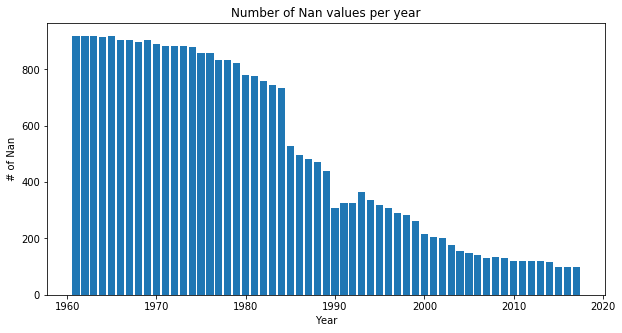

In [21]:
fig,ax=plt.subplots(figsize=(10,5))
plt.bar(pd.DataFrame(df_crops_null.year.value_counts()).sort_index().index.values, 
        pd.DataFrame(df_crops_null.year.value_counts()).sort_index().iloc[:,0].values)
plt.xlabel('Year'),plt.ylabel('# of Nan'), plt.title('Number of Nan values per year')
plt.show()

In [22]:
df_crops_null.groupby(['area','item']).agg(['min','max','count']).year

min   max  count
area         item                                 
Africa       Areca nuts          1961  1985     25
             Blueberries         1961  1988     28
             Cassava leaves      1961  1989     58
             Chestnut            1961  1984     48
             Coir                1961  1989     29
...                               ...   ...    ...
World        Tallowtree seed     1961  1984     24
             Triticale           1961  1974     28
Yugoslav SFR Citrus Fruit,Total  1961  1984     24
             Treenuts,Total      1961  1984     24
Zimbabwe     Treenuts,Total      1961  1978     36

[735 rows x 3 columns]

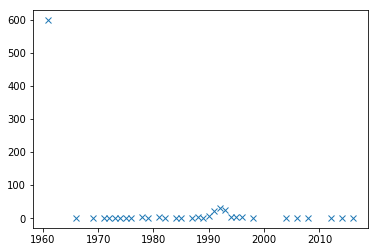

In [26]:
plt.plot(df_crops_null.groupby(['area','item']).agg(['min','max','count']).year['min'].value_counts(),'x')

<a id='cleaning-missing-values-trades'></a>

**Trades**

In [27]:
# Where are the Nan values from :
df_trade_null = cleaned_trade[cleaned_trade.value.isnull()]
df_trade_null.shape

(414679, 10)

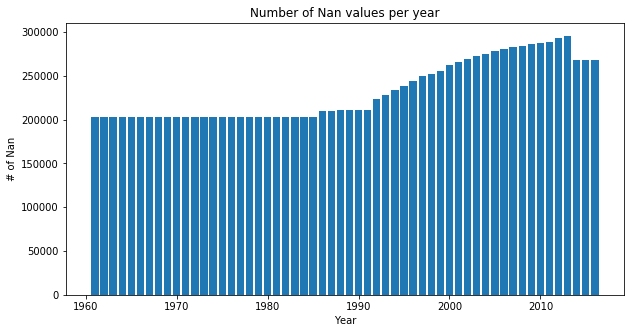

In [28]:
fig,ax=plt.subplots(figsize=(10,5))
plt.bar(pd.DataFrame(cleaned_trade.year.value_counts()).sort_index().index.values, 
        pd.DataFrame(cleaned_trade.year.value_counts()).sort_index().iloc[:,0].values)
plt.xlabel('Year'),plt.ylabel('# of Nan'), plt.title('Number of Nan values per year')
plt.show()

In [29]:
df_trade_null.groupby(['area','item']).agg(['min','max','count']).year

min   max  count
area        item                                       
Afghanistan Cereals                   1961  2008     96
            Cereals and Preparations  1961  2008     48
            Dairy Products+Eggs       1961  2008     48
            Fodder & Feeding stuff    1961  2008     96
            Meat Sheep Fresh          1961  2010    100
...                                    ...   ...    ...
Zimbabwe    Cassava Equivalent        1961  1993     66
            Crude Materials nes       1961  2003     86
            Eggs Liquid,Dried         1961  1994     34
            Flax Fib+Tow+W            1961  1993     67
            Silk                      1961  1996    104

[5949 rows x 3 columns]

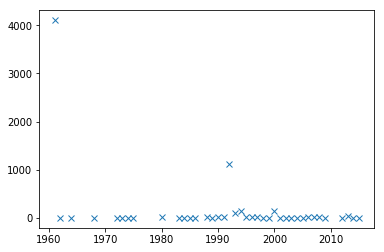

In [30]:
plt.plot(df_trade_null.groupby(['area','item']).agg(['min','max','count']).year['min'].value_counts(),'x')

In [31]:
df_trade_groupby_area_item = df_trade_null.groupby(['area','item']).agg(['min','max','count']).year
df_trade_groupby_area_item.head()

min   max  count
area        item                                       
Afghanistan Cereals                   1961  2008     96
            Cereals and Preparations  1961  2008     48
            Dairy Products+Eggs       1961  2008     48
            Fodder & Feeding stuff    1961  2008     96
            Meat Sheep Fresh          1961  2010    100

In [32]:
df_trade_groupby_area_item['min'].value_counts().head()

1961    4102
1992    1117
1994     151
2000     143
1993     109
Name: min, dtype: int64

In [33]:
df_trade_groupby_area_item[df_trade_groupby_area_item['min']==1992].index.get_level_values('area').unique()

Index(['Armenia', 'Asia', 'Azerbaijan', 'Belarus', 'Bosnia and Herzegovina',
       'Central Asia', 'China', 'Croatia', 'Eastern Asia', 'Eastern Europe',
       'Estonia', 'Europe', 'European Union', 'Georgia', 'Kazakhstan',
       'Kyrgyzstan', 'Land Locked Developing Countries', 'Latvia', 'Lithuania',
       'Low Income Food Deficit Countries', 'Melanesia', 'Northern Europe',
       'Republic of Moldova', 'Romania', 'Russian Federation',
       'Saint Vincent and the Grenadines', 'Serbia and Montenegro', 'Slovenia',
       'Southern Europe', 'Tajikistan',
       'The former Yugoslav Republic of Macedonia', 'Turkmenistan', 'Ukraine',
       'Uzbekistan', 'Western Asia', 'World'],
      dtype='object', name='area')

<a id='cleaning-missing-values-trades-2017'></a>

**Trades 2017**

In [34]:
cleaned_trade_2017.isnull().sum()

domain_code          0
domain               0
area_code            0
area                 0
element_code         0
element              0
item_code            0
item                 0
year                 0
unit                 0
value                0
flag            123608
dtype: int64

**Conclusion**

We can remove nan values. Because incomplete are for dummies, because we only want complete entries of each type 

In [35]:
cleaned_crops = cleaned_crops[~cleaned_crops.drop(['flag'],axis=1).isnull()]

In [36]:
cleaned_crops.head()

,area_code,area,item_code,item,element_code,element,year,unit,value,flag
0,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1975,ha,0.0,NaN
1,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1976,ha,5900.0,NaN
2,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1977,ha,6000.0,NaN
3,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1978,ha,6000.0,NaN
4,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1979,ha,6000.0,NaN


In [37]:
cleaned_trade = cleaned_trade[~cleaned_trade.drop(['flag'],axis=1).isnull()]

In [38]:
cleaned_trade.head()

,area_code,area,item_code,item,element_code,element,year,unit,value,flag
0,2,Afghanistan,231,Almonds shelled,5610,Import Quantity,2014,tonnes,167.0,NaN
1,2,Afghanistan,231,Almonds shelled,5610,Import Quantity,2015,tonnes,181.0,NaN
2,2,Afghanistan,231,Almonds shelled,5610,Import Quantity,2016,tonnes,845.0,NaN
3,2,Afghanistan,231,Almonds shelled,5622,Import Value,2014,1000 US$,1116.0,NaN
4,2,Afghanistan,231,Almonds shelled,5622,Import Value,2015,1000 US$,1377.0,NaN


In [39]:
cleaned_trade_2017 = cleaned_trade_2017[~cleaned_trade_2017.drop(['flag'],axis=1).isnull()]

In [40]:
cleaned_trade_2017.head()

,domain_code,domain,area_code,area,element_code,element,item_code,item,year,unit,value,flag
0,TP,Crops and livestock products,2,Afghanistan,5610,Import Quantity,231,Almonds shelled,2017,tonnes,102.0,NaN
1,TP,Crops and livestock products,2,Afghanistan,5622,Import Value,231,Almonds shelled,2017,1000 US$,758.0,NaN
2,TP,Crops and livestock products,2,Afghanistan,5910,Export Quantity,231,Almonds shelled,2017,tonnes,3335.0,NaN
3,TP,Crops and livestock products,2,Afghanistan,5922,Export Value,231,Almonds shelled,2017,1000 US$,23248.0,NaN
4,TP,Crops and livestock products,2,Afghanistan,5610,Import Quantity,221,"Almonds, with shell",2017,tonnes,41.0,NaN


<a id='merge'></a>

## 3. Merge Dataframes

<a id='merge-trades'></a>

### 3.A. Trades and Trades 2017

We will keep only Item codes and Items which are represented in both dataframe. (the rest will not be useful to us) Indeed, if we have only one prodcut that appears in 2017 and not before it does not make sense to analyse it and the same if we have one product up to 2016 but not in 2017 it doesn't make sense to analyse it.

In [41]:
raw_trade_filtered = cleaned_trade.loc[(cleaned_trade['item'].isin(cleaned_trade_2017.item.unique())) 
                                   & (cleaned_trade['item_code'].isin(cleaned_trade_2017.item_code.unique()))]

In [42]:
raw_trade_2017_filtered = cleaned_trade_2017.loc[(cleaned_trade_2017['item'].isin(cleaned_trade.item.unique())) 
                                   & (cleaned_trade_2017['item_code'].isin(cleaned_trade.item_code.unique()))]

In [43]:
trades_df = pd.concat([raw_trade_filtered,raw_trade_2017_filtered],axis=0,ignore_index=True, sort=False)


- Let's remove the non essential columns for the moment. 
    - As stated in the description of the DataFrame, the `Flag`contains only the origin of the data and can be easily removed. 
    - We don't need informaiton on the domain.

In [44]:
trades_df.drop(['flag','domain_code','domain'],axis=1,inplace=True)

In [45]:
trades_df.head()

,area_code,area,item_code,item,element_code,element,year,unit,value
0,2,Afghanistan,231,Almonds shelled,5610,Import Quantity,2014,tonnes,167.0
1,2,Afghanistan,231,Almonds shelled,5610,Import Quantity,2015,tonnes,181.0
2,2,Afghanistan,231,Almonds shelled,5610,Import Quantity,2016,tonnes,845.0
3,2,Afghanistan,231,Almonds shelled,5622,Import Value,2014,1000 US$,1116.0
4,2,Afghanistan,231,Almonds shelled,5622,Import Value,2015,1000 US$,1377.0


<a id='merge-items'></a>

### 3.B. Item labelling

For the rest of the notebook, we rename the crops dataframe.

In [64]:
crops_df = cleaned_crops

In [44]:
crops_df.columns = map(lambda name : name.lower().replace(' ', '_'), crops_df.columns) #Column names to lower case
trades_df.columns = map(lambda name : name.lower().replace(' ', '_'), trades_df.columns) #Column names to lower case

<a id='merge-items-intro'></a>

#### Intro, problem explanation

In [45]:
crops_df[crops_df['item'] == 'Almonds, with shell'].head()

,area_code,area,item_code,item,element_code,element,year,unit,value,flag
0,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1975,ha,0.0,NaN
1,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1976,ha,5900.0,NaN
2,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1977,ha,6000.0,NaN
3,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1978,ha,6000.0,NaN
4,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1979,ha,6000.0,NaN


In [46]:
trades_df[trades_df['item'] == 'Almonds shelled'].head()

,area_code,area,item_code,item,element_code,element,year,unit,value
0,2,Afghanistan,231,Almonds shelled,5610,Import Quantity,2014,tonnes,167.0
1,2,Afghanistan,231,Almonds shelled,5610,Import Quantity,2015,tonnes,181.0
2,2,Afghanistan,231,Almonds shelled,5610,Import Quantity,2016,tonnes,845.0
3,2,Afghanistan,231,Almonds shelled,5622,Import Value,2014,1000 US$,1116.0
4,2,Afghanistan,231,Almonds shelled,5622,Import Value,2015,1000 US$,1377.0


<a id='merge-items-observations'></a>

#### Observations

In [47]:
crops_items = crops_df.item.unique()

In [48]:
trades_items = trades_df.item.unique()

We notice that in the `trades_df` dataframe the items are more numerous and different than in the `crops_df`. The items are various commodities, some manufactured products and some raw products from animal and agricultural exploitation. 

As we are interested in the crops, our goal is to keep all the items, manufactured and raw, that come from an agricultural product.

**We thus make an assumption:** the first word of the items in the prod_items list is significant enough to illustrate the product. We will find those keywords, and use them to find the raw products linked to the manufactured one in the trade dataframe.

***Disclaimer: This part contains a lot of prints and describes the whole process. If you want to skip the details, you can go directly to the result [here](#end-stemmer).***

<a id='extraction1'></a>

#### Try first word as key word

In [49]:
import re
key_words = []
item_to_key = {}
for item in crops_items:
    #Clean the word, to lower case, with no special characters
    splitted_item = re.sub('[^A-Za-z0-9 ]+', '', item.lower()).split()
    key = ''
    ind = 0
    #While the 'core' word is already taken or if it is empty
    while key in key_words or key == '':
        if ind > 0 :
            key += ' '
        # We build the core word by taking the first words in the item, as we observed 
        # that the first word is significant enough  
        key += splitted_item[ind]
        ind += 1
    key_words.append(key)
    item_to_key[item] = key

Result snapshot

In [50]:
dict(list(item_to_key.items())[:10]) #Print the head of the dictionnary

{'Almonds, with shell': 'almonds',
 'Anise, badian, fennel, coriander': 'anise',
 'Apples': 'apples',
 'Apricots': 'apricots',
 'Barley': 'barley',
 'Berries nes': 'berries',
 'Cotton lint': 'cotton',
 'Cottonseed': 'cottonseed',
 'Figs': 'figs',
 'Fruit, citrus nes': 'fruit'}

The result is mostly positive. We can note some issues: the key word for the sugar beet is *sugar*, for example.

We now want to apply what we did to extract the key words from the trade items.

In [51]:
#We will check if the key word is in the item's name. 
#We then sort the core_words list to have the multiple words key words being checked first.
key_words.sort(key=lambda w : len(w), reverse=True)

In [52]:
#Sad words that did not found their match in the key words
unwanted = []

trade_item_to_key = {}
for item in trades_items:
    cleaned_item = re.sub('[^A-Za-z0-9 ]+', '', item.lower())
    for word in key_words:
        if word in cleaned_item:
            trade_item_to_key[item] = word
            break

    if trade_item_to_key.get(item, '') == '':
        trade_item_to_key[item] = 'NAC' #NAC = Not a crop
        unwanted.append(cleaned_item)

In [53]:
unwanted[:10], len(unwanted)

(['bacon and ham',
  'beeswax',
  'beet pulp',
  'beverages distilled alcoholic',
  'beverages non alcoholic',
  'bread',
  'buttermilk curdled acidified milk',
  'cake copra',
  'cheese processed',
  'chocolate products nes'],
 111)

By studying the unwanted list, we can see some items that could be *wanted*. For example, the word *potato* is unwanted, while *potatoes* is a key word. We could use a stemmer to keep these types of unwanted words.

<a id='extraction2'></a>

#### Implementation with stemmer and fixes

In [54]:
import nltk

p = nltk.PorterStemmer()

item_to_stemmed_key = {}
for item in crops_items:
    splitted_item = re.sub('[^A-Za-z0-9 ]+', '', item.lower()\
                         .replace(',', ' ').replace('  ', ' '))\
                         .split()
    key = ''
    ind = 0
    while key in item_to_stemmed_key.values() or key == '':
        if ind > 0 :
            key += ' '
        key += p.stem(splitted_item[ind])
        ind += 1
    item_to_stemmed_key[item] = key
dict(list(item_to_stemmed_key.items())[:10]) #Print the head of the dictionnary

{'Almonds, with shell': 'almond',
 'Anise, badian, fennel, coriander': 'anis',
 'Apples': 'appl',
 'Apricots': 'apricot',
 'Barley': 'barley',
 'Berries nes': 'berri',
 'Cotton lint': 'cotton',
 'Cottonseed': 'cottonse',
 'Figs': 'fig',
 'Fruit, citrus nes': 'fruit'}

In [55]:
item_to_stemmed_key['Sweet potatoes'] = 'sweet potato' #'sweet' was the core word of Sweet potatoes which can be misunderstood (ex: sweet corn)
item_to_stemmed_key['Sugar beet'] = 'sugar beet' #'sugar' was the core word of Sugar beets and sugar can also come from sugar cane.
item_to_stemmed_key['Cow peas, dry'] = 'cow pea' #'cow' was the core word of Cow peas, dry and could then be matched with cow milk produces.

item_to_stemmed_key['Chillies and peppers, dry'] = 'pepper dri' #precision is needed 
item_to_stemmed_key['Chillies and peppers, green'] = 'pepper green'#in this case

item_to_stemmed_key['Onions, shallots, green'] = 'onion' #We switch the 2 values
item_to_stemmed_key['Onions, dry'] = 'onion dri'         #as dry is more specific than multiple types of onions

item_to_stemmed_key['Vegetables Primary'] = 'veget' #Primary becomes the general stopword because there are more infos on it
item_to_stemmed_key['Vegetables, fresh nes'] = 'veget fresh'

item_to_stemmed_key['Chick peas'] = 'chick pea' #added pea as 'chick' can be the key word for 'chicken'

In [56]:
stemmed_key_words = list(item_to_stemmed_key.values())
stemmed_key_words.sort(key=lambda w : len(w), reverse=True)

unwanted2 = []
trade_item_to_stemmed_key = {}

for item in trades_items:
    cleaned_item = [p.stem(word) for word in re.sub('[^A-Za-z0-9 ]+', '', item\
                                              .lower())\
                                              .replace('+', ' ')\
                                              .replace(',', ' ')\
                                              .replace('  ', ' ')\
                                              .split()]
    cleaned_item = ' '.join(cleaned_item)
    for word in stemmed_key_words:
        if word in cleaned_item:
            trade_item_to_stemmed_key[item] = word
            break

    if trade_item_to_stemmed_key.get(item, '') == '':
        unwanted2.append(item)
        
dict(list(trade_item_to_stemmed_key.items())[:10]) #Print the head of the dictionnary

{'Almonds shelled': 'almond',
 'Anise, badian, fennel, coriander': 'anis',
 'Apples': 'appl',
 'Apricots': 'apricot',
 'Apricots, dry': 'apricot',
 'Artichokes': 'artichok',
 'Asparagus': 'asparagu',
 'Avocados': 'avocado',
 'Bananas': 'banana',
 'Barley': 'barley'}

In [57]:
len(trades_items)

343

In [58]:
unwanted2

['Bacon and ham',
 'Beeswax',
 'Beet pulp',
 'Beverages, distilled alcoholic',
 'Beverages, non alcoholic',
 'Bread',
 'Butter, cow milk',
 'Buttermilk, curdled, acidified milk',
 'Cake, copra',
 'Cheese, processed',
 'Cheese, whole cow milk',
 'Chocolate products nes',
 'Cider etc',
 'Cigarettes',
 'Cocoons, unreelable & waste',
 'Copra',
 'Cream fresh',
 'Eggs, dried',
 'Eggs, hen, in shell',
 'Eggs, liquid',
 'Eggs, other bird, in shell',
 'Fat, cattle',
 'Fat, liver prepared (foie gras)',
 'Fatty acids',
 'Fatty substance residues',
 'Food prep nes',
 'Food preparations, flour, malt extract',
 'Food wastes',
 'Forage products',
 'Fructose and syrup, other',
 'Glucose and dextrose',
 'Grease incl. lanolin wool',
 'Hair, fine',
 'Hides, cattle, wet salted',
 'Honey, natural',
 'Ice cream and edible ice',
 'Infant food',
 'Lactose',
 'Lard',
 'Macaroni',
 'Malt',
 'Maple sugar and syrups',
 'Margarine, liquid',
 'Margarine, short',
 'Meal, meat',
 'Meat, beef and veal sausages',
 'Mea

Some obvious products should stay unwanted, and we will filter them in a hardcoded manner. The rest will be to define.

In [59]:
to_define = list(filter(lambda item : \
            not 'meat' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'milk' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'egg' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'ham' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'cheese' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'fat' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'liver' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'animal' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'skin' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'cream' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'waste' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'lard' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'lactose' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'bees' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'bread' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'food' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'feed' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'glucose' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'honey' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'forage' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'pastry' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'mixes' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'silk' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'fructose' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'hides' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'macaroni' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'beverage' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'margarin' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'offals' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'husk' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'lanolin' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'hair' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'butter' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'tallow' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            not 'wool' in re.sub('[^A-Za-z0-9 ]+', '', item.lower()) and\
            True, unwanted2))
len(to_define), to_define

(29,
 ['Beet pulp',
  'Cake, copra',
  'Chocolate products nes',
  'Cider etc',
  'Cigarettes',
  'Copra',
  'Malt',
  'Maple sugar and syrups',
  'Molasses',
  'Raisins',
  'Soya sauce',
  'Sugar confectionery',
  'Sugar Raw Centrifugal',
  'Sugar refined',
  'Sweet corn frozen',
  'Sweet corn prep or preserved',
  'Vermouths & similar',
  'Wafers',
  'Waters,ice etc',
  'Whey, dry',
  'Wine',
  'Yoghurt, concentrated or not',
  'Alfalfa meal and pellets',
  'Dregs from brewing, distillation',
  'Whey, condensed',
  'Hay (unspecified)',
  'Bulgur',
  'Soya paste',
  'Sugar non-centrifugal'])

After a cleanup, we can make some assumptions:


* beetpulp is made out of sugar beets (https://en.wikipedia.org/wiki/Beet_pulp), it should be mapped to the same stemmed core words as the *sugar beet*
* copra is a product from *coconuts*
* chocolate is from *cocoa seed*
* cider is a product related to *apples*
* cigarettes are related to *tobacco*
* malt is a cereal usually made from *barley*
* molasses come from *sugar beets* and *sugar canes*
* raisins come from *grapes*
* soya sauce, curd and paste comes from *soybeans*
* vermouth is related to wine, which comes from *grapes*
* wafers are manufactured cakes, there is not one major ingredient that comes out of it
* waters, ice, etc is not made from crops
* whey comes from milk so not from crops
* wine comes from *grapes*
* beer is mostly *barley*
* dregs come from yeast, so it is not a conscern for us 
* bulgur is a whole grain, that comes from a special type of *wheat*
* cane tops ?
* turnips are part of *carrot and turnips*
* vitamins is manufactured from too many ingredients to find a crop
* popcorn comes from a special type of *corn*
* Sweet corn is related to *Maize*
* All the sugars come from multiple origins:
  *   Maple sugar comes from maple, which is not in our production dataset
  * There are no generalities to where the other sugars are from (sugar beet or sugar canes, thus we will link the sugar to both)






From these observations, some unwanted words can be linked to a "core stemmed" word. Some are not as obvious.

In [60]:
trade_item_to_stemmed_key['Beet pulp'] = item_to_stemmed_key['Sugar beet']
trade_item_to_stemmed_key['Cake, copra'] = item_to_stemmed_key['Coconuts']
trade_item_to_stemmed_key['Chocolate products nes'] = item_to_stemmed_key['Cocoa, beans']
trade_item_to_stemmed_key['Cider etc'] = item_to_stemmed_key['Apples']
trade_item_to_stemmed_key['Cigarettes'] = item_to_stemmed_key['Tobacco, unmanufactured']
trade_item_to_stemmed_key['Copra'] = item_to_stemmed_key['Coconuts']
trade_item_to_stemmed_key['Malt'] = item_to_stemmed_key['Barley']
trade_item_to_stemmed_key['Molasses'] = item_to_stemmed_key['Sugar beet'] + ' | ' + item_to_stemmed_key['Sugar cane']
trade_item_to_stemmed_key['Raisins'] = item_to_stemmed_key['Grapes']
trade_item_to_stemmed_key['Soya sauce'] = item_to_stemmed_key['Soybeans']
trade_item_to_stemmed_key['Vermouths & similar'] = item_to_stemmed_key['Grapes']
trade_item_to_stemmed_key['Wine'] = item_to_stemmed_key['Grapes']
trade_item_to_stemmed_key['Beer'] = item_to_stemmed_key['Barley']
trade_item_to_stemmed_key['Wine+Vermouth+Sim.'] = item_to_stemmed_key['Grapes']
trade_item_to_stemmed_key['Bulgur'] = item_to_stemmed_key['Wheat']
trade_item_to_stemmed_key['Cane tops'] = item_to_stemmed_key['Sugar cane']
#trade_item_to_stemmed_key['Soya curd'] = item_to_stemmed_key['Soybeans']
trade_item_to_stemmed_key['Soya paste'] = item_to_stemmed_key['Soybeans']
trade_item_to_stemmed_key['Turnips for fodder'] = item_to_stemmed_key['Carrots and turnips']
trade_item_to_stemmed_key['Popcorn'] = item_to_stemmed_key['Maize']

trade_item_to_stemmed_key['Sugar confectionery'] = item_to_stemmed_key['Sugar beet'] + ' | ' + item_to_stemmed_key['Sugar cane']
trade_item_to_stemmed_key['Sugar Raw Centrifugal'] = item_to_stemmed_key['Sugar beet'] + ' | ' + item_to_stemmed_key['Sugar cane']
trade_item_to_stemmed_key['Sugar refined'] = item_to_stemmed_key['Sugar beet'] + ' | ' + item_to_stemmed_key['Sugar cane']
trade_item_to_stemmed_key['Sugar, nes'] = item_to_stemmed_key['Sugar beet'] + ' | ' + item_to_stemmed_key['Sugar cane']
trade_item_to_stemmed_key['Sugar,Total (Raw Equiv.)'] = item_to_stemmed_key['Sugar beet'] + ' | ' + item_to_stemmed_key['Sugar cane']
trade_item_to_stemmed_key['Sugar non-centrifugal'] = item_to_stemmed_key['Sugar beet'] + ' | ' + item_to_stemmed_key['Sugar cane']
trade_item_to_stemmed_key['Sweet corn frozen'] = item_to_stemmed_key['Maize']
trade_item_to_stemmed_key['Sweet corn prep or preserved'] = item_to_stemmed_key['Maize']

In [61]:
#Oat can be the key word for 'goat'
for key in trade_item_to_stemmed_key.keys():
    if trade_item_to_stemmed_key[key] == 'oat':
        print(key)

Meat, goat
Oats
Oats rolled
Offals, edible, goats


In [62]:
#Crude Materials got the key word mat related to the product Maté
del trade_item_to_stemmed_key['Crude materials']

#Goat deletion
del trade_item_to_stemmed_key['Meat, goat']
del trade_item_to_stemmed_key['Offals, edible, goats']

In [63]:
trade_item_to_stemmed_key['Nuts, prepared (exc. groundnuts)']

'groundnut'

In [64]:
#Groundnut was selected here, while it is specified 'excluded'
trade_item_to_stemmed_key['Nuts, prepared (exc. groundnuts)'] = item_to_stemmed_key['Nuts, nes']

In [63]:
crops_df['item_key'] = crops_df.item.map(lambda item: item_to_stemmed_key.get(item, 'NAC')) #NAC = Not A Crop
trades_df['item_key'] = trades_df.item.map(lambda item: trade_item_to_stemmed_key.get(item, 'NAC'))

NameError: name 'crops_df' is not defined

<a id='end-stemmer'></a>

Now the key item from the crops is added to the trades  

In [65]:
crops_df[['item', 'item_key']].head()

KeyError: "['item_key'] not in index"

In [67]:
trades_df[['item', 'item_key']].head()

,item,item_key
0,Almonds shelled,almond
1,Almonds shelled,almond
2,Almonds shelled,almond
3,Almonds shelled,almond
4,Almonds shelled,almond


In [68]:
#trades_df.merge(crops_df, on=['item_key'], how='outer',suffixes=('_trades', '_crops'))

We would now want to merge the two dataframes based on the `item_key` column. The above cell is very computanionally heavy and we will probably use pyspark to do it, if we need it later on.

<a id='group-countries'></a>

## 4. Group by countries

The idea behind grouping by countries is to analyse some crops and some commodities trades such as the exportation or the importation by groups. Grouping by countries will allow to vizualise the production or the importation for example on a larger scale. We will first analyse the continents ie. Africa or Asia ...e and then look at more detailed statistics on the country level if it's relvant. 

In order to do so, we have downloaded an extra dataset which contains all the different groups of countries (Continents, Sub-Continents, Economic Entities ... ) and which contries are part of it. The file can be dowloaded [here](http://www.fao.org/faostat/en/#data/TP) its under the `Country Group` when one click on the `Definitions and standards - Crops and livestock products` button.

It's really a nice file because one can find the countries belonging to each group as well as their Country Code that can be used with the previous dataset or the ISO 02 or ISO 03 codes that can be useful when some mapping need to be done.

In [66]:
# Load the dataset
df_country = pd.read_csv('Data/GroupsCountry.csv')
df_country.columns = map(lambda name : name.lower().replace(' ', '_'), df_country.columns) #Column names to lower case
df_country.head()

,country_group_code,country_group,country_code,country,m49_code,iso2_code,iso3_code
0,5100,Africa,4,Algeria,12,DZ,DZA
1,5100,Africa,7,Angola,24,AO,AGO
2,5100,Africa,53,Benin,204,BJ,BEN
3,5100,Africa,20,Botswana,72,BW,BWA
4,5100,Africa,233,Burkina Faso,854,BF,BFA


In [67]:
# Unique Coutry Group id, ie. 5100 for Africa, 5000 for World, 5500 for Oceania ...
list_group = df_country['country_group_code'].unique()

In [68]:
# Display the id of the countries that are in the first item of the group (0)
df_country[df_country['country_group_code']==list_group[0]]['country_code'].unique()

array([  4,   7,  53,  20, 233,  29,  35,  32,  37,  39,  45,  46, 107,
       250,  72,  59,  61, 178, 209, 238,  62,  74,  75,  81,  90, 175,
       114, 122, 123, 124, 129, 130, 133, 136, 137, 143, 144, 147, 158,
       159, 184, 193, 195, 196, 197, 201, 202, 277, 276, 206, 217, 222,
       226, 215, 251, 181], dtype=int64)

In [69]:
# Create a dictionnary that regroup all the countries in one country group
dicts = {}
keys = list_group
for i in range(len(list_group)):
    dicts[list_group[i]]= df_country[df_country['country_group_code']==list_group[i]]['country_code'].unique()

In [70]:
# Get the name of each country group
list_country_code = df_country['country_group'].unique()

In [71]:
# Create dictionnary for name + subregions
dicts_country = {}
keys = list_group
for i in range(len(list_group)):
    dicts_country[list_group[i]] = list_country_code[i]

In [72]:
# Display all the suregions and their name
pd.DataFrame.from_dict(dicts_country,orient='index',columns=['regions']).head(15)

,regions
5100,Africa
5200,Americas
5300,Asia
5501,Australia and New Zealand
5206,Caribbean
5204,Central America
5301,Central Asia
5101,Eastern Africa
5302,Eastern Asia
5401,Eastern Europe


Let's print an example. On the cell below we want isolate all the countries in `Northern Europe : 5402` on the dictionnary above.

In [73]:
crops_df[crops_df['area_code'].isin(dicts.get(5402))]

,area_code,area,item_code,item,element_code,element,year,unit,value,flag
471636,54,Denmark,711,"Anise, badian, fennel, coriander",5312,Area harvested,1961,ha,85.0,NaN
471637,54,Denmark,711,"Anise, badian, fennel, coriander",5312,Area harvested,1962,ha,161.0,NaN
471638,54,Denmark,711,"Anise, badian, fennel, coriander",5312,Area harvested,1963,ha,154.0,NaN
471639,54,Denmark,711,"Anise, badian, fennel, coriander",5312,Area harvested,1964,ha,135.0,NaN
471640,54,Denmark,711,"Anise, badian, fennel, coriander",5312,Area harvested,1965,ha,192.0,NaN
...,...,...,...,...,...,...,...,...,...,...
1642406,229,United Kingdom,1735,Vegetables Primary,5510,Production,2013,tonnes,2593779.0,NaN
1642407,229,United Kingdom,1735,Vegetables Primary,5510,Production,2014,tonnes,2802695.0,NaN
1642408,229,United Kingdom,1735,Vegetables Primary,5510,Production,2015,tonnes,2564931.0,NaN
1642409,229,United Kingdom,1735,Vegetables Primary,5510,Production,2016,tonnes,2608460.0,NaN


In [74]:
trades_df[trades_df['area_code'].isin(dicts.get(5100))]

,area_code,area,item_code,item,element_code,element,year,unit,value
36020,4,Algeria,862,Alfalfa meal and pellets,5610,Import Quantity,1968,tonnes,135.0
36021,4,Algeria,862,Alfalfa meal and pellets,5610,Import Quantity,1969,tonnes,680.0
36022,4,Algeria,862,Alfalfa meal and pellets,5610,Import Quantity,1970,tonnes,234.0
36023,4,Algeria,862,Alfalfa meal and pellets,5610,Import Quantity,1971,tonnes,46.0
36024,4,Algeria,862,Alfalfa meal and pellets,5610,Import Quantity,1972,tonnes,70.0
...,...,...,...,...,...,...,...,...,...
9805019,181,Zimbabwe,988,"Wool, degreased",5622,Import Value,2017,1000 US$,2.0
9805020,181,Zimbabwe,987,"Wool, greasy",5610,Import Quantity,2017,tonnes,1.0
9805021,181,Zimbabwe,987,"Wool, greasy",5622,Import Value,2017,1000 US$,2.0
9805022,181,Zimbabwe,892,"Yoghurt, concentrated or not",5910,Export Quantity,2017,tonnes,2.0


<a id='group-crops'></a>

## 5. Group by crops 

Grouping crops by category or type could be interesting to look for trends. There are a lot a different Items in crops both in the trades and the crops dataset which can make the vizualization difficult. 

On the website : http://www.fao.org/faostat/en/#data/TP when we download the file `Item Group` in `Definitions and standards - Crops and livestock products` we observe all the item codes for the different crops. The Item Group Code is the main category which contains many different crops. However those categories look a lot unbalanced, with the number 1882 - Agricult.Products, Total containing most of the crops and the vegetables. 

Let's take an example for the quinoa. This is what we got :

In [75]:
#Quickly load the data : 
group_crops_df = pd.read_csv('data/GroupCrops.csv')
group_crops_df.columns = map(lambda name : name.lower().replace(' ', '_'), group_crops_df.columns) #Column names to lower case
group_crops_df.shape

(2415, 9)

In [76]:
#Look at the item Quinoa :
group_crops_df[group_crops_df.item=='Quinoa']

,item_group_code,item_group,item_code,item,factor,hs_code,hs07_code,hs12_code,cpc_code
448,1882,"Agricult.Products, Total",92,Quinoa,1.0,NaN,100890,100850,01194
696,1944,Cereals,92,Quinoa,1.0,NaN,100890,100850,01194
743,1888,Cereals and Preparations,92,Quinoa,1.0,NaN,100890,100850,01194
760,1948,Cereals nes,92,Quinoa,1.0,NaN,100890,100850,01194
1362,1883,Food and Animals,92,Quinoa,1.0,NaN,100890,100850,01194
1741,1982,Food Excl Fish,92,Quinoa,1.0,NaN,100890,100850,01194


We see that the quinoa which has always the same `Item Code = 92`, belongs to different `Item Group Code` ( Agricult.Products, Total, Cereals , ...). Hence using the `Item Group Code` to properly classify the group in which the quinoa belongs is not correct. If we add the contribution of all the main groups then the total will be bigger than the real production if the same crops or products can be found in multiple groups. 

As a solution, decided to use the HS12 Code, which give for each product an unique ID and each product belongs to one group. The HS12 data which can be donwloaded [here](http://unstats.un.org/unsd/tradekb/Attachment439.aspx?AttachmentType=1) is a system based by the UN Commerce and Trading 

We have the folowing product : `100890` (Quinoa)

There is two aggreagation levels : 

- If we take the first two numbers (10) then we will have the main category (Cereals). 
- If we take the four first numbers (1008) then we go more specific category (BuckWheat, Millet, and canary seeds; other cereals). For example, the other groups in the cereals category are : Oats, Rice, Maize (Corn), Wheat and Meslin, Barley and Rye. 

In [77]:
# Load the UN Comtrade Commodity Classifications :
UNCCC_df = pd.read_excel('data/UNCCC.xlsx')

In [78]:
HS12_df = UNCCC_df[UNCCC_df.Classification=='H4'] # H4 corresponds to HS12, H3 to HS07 ...

In [79]:
# Let's have a snapshot of the dataset :
HS12_df

,Classification,Code,Description,Code Parent,Level,isLeaf
25827,H4,01,Animals; live,TOTAL,2,0
25828,H4,0101,"Horses, asses, mules and hinnies; live",01,4,0
25829,H4,010121,"Horses; live, pure-bred breeding animals",0101,6,1
25830,H4,010129,"Horses; live, other than pure-bred breeding an...",0101,6,1
25831,H4,010130,Asses; live,0101,6,1
...,...,...,...,...,...,...
32351,H4,970600,Antiques; of an age exceeding one hundred years,9706,6,1
32352,H4,99,Commodities not specified according to kind,TOTAL,2,0
32353,H4,9999,Commodities not specified according to kind,99,4,0
32354,H4,999999,Commodities not specified according to kind,9999,6,1


For example, we want to look if we can retrieve our main category for the quinoa that we looked at before : 

In [80]:
HS12_df[HS12_df.Code=='10'] # Let's recall that the category 10 is for cereals

,Classification,Code,Description,Code Parent,Level,isLeaf
26445,H4,10,Cereals,TOTAL,2,0


Clean this dataset : 

In [81]:
# Number of null items in the "HS12 Code"
group_crops_df.isnull().sum()

item_group_code       0
item_group            0
item_code             0
item                  0
factor                2
hs_code            2415
hs07_code            16
hs12_code            16
cpc_code             18
dtype: int64

In [82]:
group_crops_df[group_crops_df['hs12_code'].isnull()]

,item_group_code,item_group,item_code,item,factor,hs_code,hs07_code,hs12_code,cpc_code
140,1882,"Agricult.Products, Total",654,"Dregs from brewing, distillation",1.0,NaN,NaN,NaN,39160
289,1882,"Agricult.Products, Total",389,"Juice, tomato, concentrated",1.0,NaN,NaN,NaN,NaN
384,1882,"Agricult.Products, Total",1159,"Offals, other camelids",1.0,NaN,NaN,NaN,NaN
454,1882,"Agricult.Products, Total",30,Rice - total (Rice milled equivalent),NaN,NaN,NaN,NaN,NaN
983,1892,Fodder & Feeding stuff,654,"Dregs from brewing, distillation",1.0,NaN,NaN,NaN,39160
1135,1883,Food and Animals,654,"Dregs from brewing, distillation",1.0,NaN,NaN,NaN,39160
1241,1883,Food and Animals,389,"Juice, tomato, concentrated",1.0,NaN,NaN,NaN,NaN
1326,1883,Food and Animals,1159,"Offals, other camelids",1.0,NaN,NaN,NaN,NaN
1604,1982,Food Excl Fish,389,"Juice, tomato, concentrated",1.0,NaN,NaN,NaN,NaN
1689,1982,Food Excl Fish,1159,"Offals, other camelids",1.0,NaN,NaN,NaN,NaN


We observed that some entries of this dataset are `np.nan`. Because there are only few of them and we cannot even map any them to any of the HS07 or HS12 code, we decided to remove them. Also, if we look at the `Rice - total` which cannot be mapped one can found the `Rice` by looking at its Id so it's not an issue to delete it. 

In [83]:
group_crops_df[group_crops_df['hs12_code']=='100620']

,item_group_code,item_group,item_code,item,factor,hs_code,hs07_code,hs12_code,cpc_code
456,1882,"Agricult.Products, Total",28,"Rice, husked",1.0,NaN,100620,100620,23162
698,1944,Cereals,28,"Rice, husked",1.0,NaN,100620,100620,23162
745,1888,Cereals and Preparations,28,"Rice, husked",1.0,NaN,100620,100620,23162
1367,1883,Food and Animals,28,"Rice, husked",1.0,NaN,100620,100620,23162
1748,1982,Food Excl Fish,28,"Rice, husked",1.0,NaN,100620,100620,23162
2321,1946,Rice,28,"Rice, husked",1.0,NaN,100620,100620,23162


In [84]:
# df group crops with the nan values removed
group_crops_cleaned_df = group_crops_df[~group_crops_df['hs12_code'].isnull()]

In [85]:
# If the items is assigned mutliple labels, we only keep the first one
HS12_Code = group_crops_cleaned_df['hs12_code'].str.split(', ',expand=True).loc[:,0]

In [86]:
group_crops_cleaned_df = pd\
                            .concat([group_crops_cleaned_df,HS12_Code],axis=1)\
                            .drop(['factor','hs_code','hs07_code','cpc_code','hs12_code'],axis=1)

In [87]:
group_crops_cleaned_df.rename(columns={0:'hs12_code'},inplace=True)

We add two new columns, the first `Parent Group` will contain the main group specified by the first two digits and the second column `Child Group` will show a more specific group with a lower hierarchical order with the first four digits. 

In [88]:
group_crops_cleaned_df['parent_group'] = group_crops_cleaned_df['hs12_code'].str[:2].astype(int)
group_crops_cleaned_df['child_group'] = group_crops_cleaned_df['hs12_code'].str[:4].astype(int)

In [89]:
# Let's look at a snpashot : 
group_crops_cleaned_df.head()

,item_group_code,item_group,item_code,item,hs12_code,parent_group,child_group
0,1882,"Agricult.Products, Total",800,Agave fibres nes,530500,53,5305
1,1882,"Agricult.Products, Total",862,Alfalfa meal and pellets,121410,12,1214
2,1882,"Agricult.Products, Total",231,Almonds shelled,080212,8,802
3,1882,"Agricult.Products, Total",221,"Almonds, with shell",080211,8,802
4,1882,"Agricult.Products, Total",1171,Animals live nes,010611,1,106


In [90]:
# Check that the columns Parent Group and Child Group are of type int or float
group_crops_cleaned_df.dtypes

item_group_code     int64
item_group         object
item_code           int64
item               object
hs12_code          object
parent_group        int32
child_group         int32
dtype: object

In [91]:
# Number of parent groups 
print(f' Number of Parent Group : {group_crops_cleaned_df.parent_group.nunique()}')

 Number of Parent Group : 29


In [92]:
# Final dataset used for the mapping of each crop : 
group_crops_cleaned_df = group_crops_cleaned_df\
                            .drop(['item_group_code','item_group'],axis=1)\
                            .groupby(['item','item_code','hs12_code','parent_group','child_group'])\
                            .count()\
                            .reset_index()

In [93]:
print(group_crops_cleaned_df.shape)

group_crops_cleaned_df.head()

(563, 5)


,item,item_code,hs12_code,parent_group,child_group
0,Agave fibres nes,800,530500,53,5305
1,Alfalfa meal and pellets,862,121410,12,1214
2,Almonds shelled,231,080212,8,802
3,"Almonds, with shell",221,080211,8,802
4,Animals live nes,1171,010611,1,106


In [94]:
# Merging on item_code only for the trade_df at the moment
df_final = trades_df.merge(group_crops_cleaned_df, left_on='item_code',right_on='item_code')
df_final.head()

,area_code,area,item_code,item_x,element_code,element,year,unit,value,item_y,hs12_code,parent_group,child_group
0,2,Afghanistan,231,Almonds shelled,5610,Import Quantity,2014,tonnes,167.0,Almonds shelled,080212,8,802
1,2,Afghanistan,231,Almonds shelled,5610,Import Quantity,2015,tonnes,181.0,Almonds shelled,080212,8,802
2,2,Afghanistan,231,Almonds shelled,5610,Import Quantity,2016,tonnes,845.0,Almonds shelled,080212,8,802
3,2,Afghanistan,231,Almonds shelled,5622,Import Value,2014,1000 US$,1116.0,Almonds shelled,080212,8,802
4,2,Afghanistan,231,Almonds shelled,5622,Import Value,2015,1000 US$,1377.0,Almonds shelled,080212,8,802


In [95]:
# Printing the main categories (parent_group)
df_final['parent_group'].unique()

array([ 8,  9,  7,  2, 10, 22, 15, 23, 19,  4, 18, 24, 50, 21, 12, 52,  5,
       16, 38, 53, 11, 17, 20, 51, 41, 40, 14], dtype=int64)

List of all the main categories : 

- 02 : Meat and edible meat offal
- 04 : Dairy produce; birds' eggs; natural honey; edible products of animal origin, not elsewhere -specified or included
- 05 : Animal originated products; not elsewhere specified or included
- 07 : Vegetables and certain roots and tubers; edible
- 08 : Fruit and nuts, edible; peel of citrus fruit or melons  
- 09 : Coffee, tea, mate and spices
- 10 : Cereals
- 11 : Products of the milling industry; malt, starches, inulin, wheat gluten
- 12 : Oil seeds and oleaginous fruits; miscellaneous grains, seeds and fruit, industrial or medicinal plants; straw and fodder
- 14 : Vegetable plaiting materials; vegetable products not elsewhere specified or included
- 15 : Animal or vegetable fats and oils and their cleavage products; prepared animal fats; animal or vegetable waxes
- 16 : Meat, fish or crustaceans, molluscs or other aquatic invertebrates; preparations thereof
- 17 : Sugars and sugar confectionery
- 18 : Cocoa and cocoa preparations
- 19 : Preparations of cereals, flour, starch or milk; pastrycooks' products
- 20 : Preparations of vegetables, fruit, nuts or other parts of plants
- 21 : Miscellaneous edible preparations
- 22 : Beverages, spirits and vinegar 
- 23 : Food industries, residues and wastes thereof; prepared animal fodder
- 24 : Tobacco and manufactured tobacco substitutes
- 38 : Chemical products n.e.c.
- 40 : Rubber and articles thereof
- 41 : Raw hides and skins (other than furskins) and leather
- 50 : Silk
- 51 : Wool, fine or coarse animal hair; horsehair yarn and woven fabric
- 52 : Cotton
- 53 : Vegetable textile fibres; paper yarn and woven fabrics of paper yarn

**Example** : It's really easy to extract in two line of codes all the crops in group 10 (Cereals)

In [96]:
list_crops_group = df_final[df_final['parent_group']==10]['child_group'].unique()

In [97]:
example = df_final[df_final['child_group'].isin(list_crops_group)]

In [98]:
example.head()

,area_code,area,item_code,item_x,element_code,element,year,unit,value,item_y,hs12_code,parent_group,child_group
307762,2,Afghanistan,44,Barley,5610,Import Quantity,1995,tonnes,3800.0,Barley,100310,10,1003
307763,2,Afghanistan,44,Barley,5610,Import Quantity,1996,tonnes,0.0,Barley,100310,10,1003
307764,2,Afghanistan,44,Barley,5610,Import Quantity,1997,tonnes,0.0,Barley,100310,10,1003
307765,2,Afghanistan,44,Barley,5610,Import Quantity,1998,tonnes,0.0,Barley,100310,10,1003
307766,2,Afghanistan,44,Barley,5610,Import Quantity,1999,tonnes,0.0,Barley,100310,10,1003


<a id='import'></a>

## 6. Import-export Dataframe

The main motive behind this part is to change how the value are presented. Indeed, at the moment all different values (Import or Export quantities ... ) are presented below each other which is not efficient to make some calculations between them. To solve this issue and make our life easier, we'll create dummies with the `get_dummies`method and a custom aggregation function will group all the data per element per year.  

In [99]:
df_dummy = pd.get_dummies(df_final.element)

In [100]:
df_dummy.head()

,Export Quantity,Export Value,Import Quantity,Import Value
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,0,1
4,0,0,0,1


In [101]:
df_merged_dummies = pd.concat([df_final, df_dummy],axis=1)
df_merged_dummies.columns = map(lambda name : name.lower().replace(' ', '_'), df_merged_dummies.columns) #Column names to lower case
df_merged_dummies.head()

,area_code,area,item_code,item_x,element_code,element,year,unit,value,item_y,hs12_code,parent_group,child_group,export_quantity,export_value,import_quantity,import_value
0,2,Afghanistan,231,Almonds shelled,5610,Import Quantity,2014,tonnes,167.0,Almonds shelled,080212,8,802,0,0,1,0
1,2,Afghanistan,231,Almonds shelled,5610,Import Quantity,2015,tonnes,181.0,Almonds shelled,080212,8,802,0,0,1,0
2,2,Afghanistan,231,Almonds shelled,5610,Import Quantity,2016,tonnes,845.0,Almonds shelled,080212,8,802,0,0,1,0
3,2,Afghanistan,231,Almonds shelled,5622,Import Value,2014,1000 US$,1116.0,Almonds shelled,080212,8,802,0,0,0,1
4,2,Afghanistan,231,Almonds shelled,5622,Import Value,2015,1000 US$,1377.0,Almonds shelled,080212,8,802,0,0,0,1


In [102]:
# This cell assign the actual corresponding value to the dummies 
df_merged_dummies.loc[df_merged_dummies['import_quantity']==1,'import_quantity'] = df_merged_dummies.loc[df_merged_dummies['import_quantity']==1,'value']
df_merged_dummies.loc[df_merged_dummies['import_value']==1,'import_value'] = df_merged_dummies.loc[df_merged_dummies['import_value']==1,'value']
df_merged_dummies.loc[df_merged_dummies['export_quantity']==1,'export_quantity'] = df_merged_dummies.loc[df_merged_dummies['export_quantity']==1,'value']
df_merged_dummies.loc[df_merged_dummies['export_value']==1,'export_value'] = df_merged_dummies.loc[df_merged_dummies['export_value']==1,'value']

In [103]:
list_features_to_drop = ['item_code','element_code','element','value','flag','domain_code','domain','item_y']

In [161]:
df_import_export = df_merged_dummies.groupby(['area','item_x','year']).agg({
    'area_code' : 'first',
    'unit' : 'first',
    'hs12_code' : 'first',
    'parent_group' : 'first',
    'child_group' : 'first',
    'export_quantity' : 'sum',
    'export_value' : 'sum',
    'import_quantity' : 'sum',
    'import_value'  : 'sum'    
}).reset_index()

In [162]:
df_import_export.head()

,area,item_x,year,area_code,unit,hs12_code,parent_group,child_group,export_quantity,export_value,import_quantity,import_value
0,Afghanistan,Almonds shelled,1961,2,tonnes,080212,8,802,0.0,0.0,0.0,0.0
1,Afghanistan,Almonds shelled,1962,2,tonnes,080212,8,802,0.0,0.0,0.0,0.0
2,Afghanistan,Almonds shelled,1963,2,tonnes,080212,8,802,0.0,0.0,0.0,0.0
3,Afghanistan,Almonds shelled,1964,2,tonnes,080212,8,802,0.0,0.0,0.0,0.0
4,Afghanistan,Almonds shelled,1965,2,tonnes,080212,8,802,0.0,0.0,0.0,0.0


Here is the final dataframe for the `trades`.

<a id='plots'></a>

## 7. Plots

With the dataframe that we have above, our possibillities are endless. We can plot for example, the import of cereals in Europe during the time period, we can look at each of the products inside that category. We can for example look at the exportations of the cereals from Africa also. 

We can also compute some new features : `Profit` which is the difference of value for the import export ....


<a id='plots1'></a>
### 7.A First Example : Biggest importers and exporters 

In [106]:
df_cereals = df_import_export[df_import_export['parent_group']==10]

In [107]:
df_cereals_2017 = df_cereals[df_cereals.year==2017].groupby(['area','area_code'])['export_quantity','export_value','import_quantity','import_value'].sum().reset_index()
df_cereals_2017.head()

,area,area_code,export_quantity,export_value,import_quantity,import_value
0,Afghanistan,2,0.0,0.0,328958.0,65992.0
1,Albania,3,37.0,113.0,272842.0,54101.0
2,Algeria,4,14.0,14.0,12775277.0,2671188.0
3,American Samoa,5,0.0,0.0,0.0,0.0
4,Angola,7,797.0,78.0,216999.0,51800.0


In [108]:
# Let's print the 10 biggest importers and exporters : 
df_cereals_2017.sort_values(['import_quantity'],ascending=False).head(10)

,area,area_code,export_quantity,export_value,import_quantity,import_value
39,China,351,154018.0,63143.0,27435730.0,5855649.0
96,Japan,110,195.0,200.0,22079736.0,5052770.0
43,"China, mainland",41,153667.0,62890.0,21438037.0,4571459.0
119,Mexico,138,2149171.0,624832.0,20840595.0,4081801.0
61,Egypt,59,4278.0,2744.0,18532028.0,4357743.0
173,Spain,203,630089.0,222636.0,15513394.0,3027502.0
161,Saudi Arabia,194,2230.0,606.0,15020985.0,2895491.0
94,Italy,106,696629.0,241979.0,13761959.0,3009580.0
150,Republic of Korea,117,4189.0,9757.0,13656640.0,2785673.0
2,Algeria,4,14.0,14.0,12775277.0,2671188.0


In [109]:
df_cereals_2017.sort_values(['export_quantity'],ascending=False).head(10)

,area,area_code,export_quantity,export_value,import_quantity,import_value
195,United States of America,231,86358436.0,16827123.0,6190332.0,1641883.0
153,Russian Federation,185,43046028.0,7448886.0,497361.0,257779.0
191,Ukraine,230,41825476.0,6501184.0,65310.0,143873.0
6,Argentina,9,39859482.0,6786595.0,11205.0,29646.0
9,Australia,10,31231578.0,6376859.0,4523.0,4269.0
25,Brazil,21,29888511.0,4736025.0,7985968.0,1525365.0
34,Canada,33,27464137.0,6256569.0,1209541.0,375710.0
70,France,68,25422121.0,5504144.0,1581060.0,534827.0
75,Germany,79,11158947.0,2295867.0,9203880.0,2074268.0
152,Romania,183,11013790.0,2197016.0,2318666.0,485470.0


<a id='plots2'></a>
### 7.B Second Example : Net Exported quantity and profit in Europe

In [115]:
df_cereals_2017['diff_quantity'] = df_cereals_2017['export_quantity'] - df_cereals_2017['import_quantity']
df_cereals_2017['profit'] = df_cereals_2017['export_value'] - df_cereals_2017['import_value']
df_cereals_2017

,area,area_code,export_quantity,export_value,import_quantity,import_value,diff_quantity,profit
0,Afghanistan,2,0.0,0.0,328958.0,65992.0,-328958.0,-65992.0
1,Albania,3,37.0,113.0,272842.0,54101.0,-272805.0,-53988.0
2,Algeria,4,14.0,14.0,12775277.0,2671188.0,-12775263.0,-2671174.0
3,American Samoa,5,0.0,0.0,0.0,0.0,0.0,0.0
4,Angola,7,797.0,78.0,216999.0,51800.0,-216202.0,-51722.0
...,...,...,...,...,...,...,...,...
199,Venezuela (Bolivarian Republic of),236,15.0,8.0,2489826.0,701866.0,-2489811.0,-701858.0
200,Viet Nam,237,84114.0,27786.0,12453876.0,2534986.0,-12369762.0,-2507200.0
201,Yemen,249,93.0,36.0,3794419.0,796378.0,-3794326.0,-796342.0
202,Zambia,251,327585.0,97956.0,56843.0,23863.0,270742.0,74093.0


In [116]:
#import pickle
#df_cereals_2017.to_pickle('df_cereals_2017.pkl')

In [117]:
# Let's print value for Europe (5400) : 
df_cereals_2017_europe = df_cereals_2017[df_cereals_2017['area_code'].isin(dicts.get(5400))]
df_cereals_2017_europe.head(10)

,area,area_code,export_quantity,export_value,import_quantity,import_value,diff_quantity,profit
1,Albania,3,37.0,113.0,272842.0,54101.0,-272805.0,-53988.0
10,Austria,11,1327989.0,442454.0,2315653.0,488395.0,-987664.0,-45941.0
16,Belarus,57,979.0,407.0,330144.0,94263.0,-329165.0,-93856.0
17,Belgium,255,1246859.0,313552.0,8360394.0,1742552.0,-7113535.0,-1429000.0
23,Bosnia and Herzegovina,80,59460.0,14115.0,699770.0,135572.0,-640310.0,-121457.0
28,Bulgaria,27,5473852.0,1013753.0,427972.0,119777.0,5045880.0,893976.0
49,Croatia,98,906699.0,174822.0,163810.0,54977.0,742889.0,119845.0
52,Czechia,167,3485559.0,659110.0,255141.0,88844.0,3230418.0,570266.0
56,Denmark,54,1992065.0,400170.0,526868.0,161073.0,1465197.0,239097.0
64,Estonia,63,905232.0,167859.0,94526.0,19622.0,810706.0,148237.0


**Load GeoPandas**

Summary : from geopandas we can plot each country with their iso_a3 code. From df_country we have the mapping from Iso_a3 and the country code obtained in the cleaned and processed dataset import_export

In [143]:
df_import_export = df_import_export.merge(df_country[['iso3_code','country_code']],left_on='area_code',right_on='country_code').drop(['area_code'],axis=1)

In [145]:
df_import_export.head()

,area,item_x,year,unit,hs12_code,parent_group,child_group,export_quantity,export_value,import_quantity,import_value,iso3_code,country_code
0,Afghanistan,Almonds shelled,1961,tonnes,080212,8,802,0.0,0.0,0.0,0.0,AFG,2
1,Afghanistan,Almonds shelled,1961,tonnes,080212,8,802,0.0,0.0,0.0,0.0,AFG,2
2,Afghanistan,Almonds shelled,1961,tonnes,080212,8,802,0.0,0.0,0.0,0.0,AFG,2
3,Afghanistan,Almonds shelled,1961,tonnes,080212,8,802,0.0,0.0,0.0,0.0,AFG,2
4,Afghanistan,Almonds shelled,1961,tonnes,080212,8,802,0.0,0.0,0.0,0.0,AFG,2


In [149]:
df_cereals = df_import_export[df_import_export['parent_group']==10]
df_cereals_2017 = df_cereals[df_cereals.year==2017].groupby(['area','country_code','iso3_code'])['export_quantity','export_value','import_quantity','import_value'].sum().reset_index()
df_cereals_2017['diff_quantity'] = df_cereals_2017['export_quantity'] - df_cereals_2017['import_quantity']
df_cereals_2017['profit'] = df_cereals_2017['export_value'] - df_cereals_2017['import_value']

df_cereals_2017.to_pickle('df_cereals_2017_folium.pkl')

In [150]:
df_cereals_2017

,area,country_code,iso3_code,export_quantity,export_value,import_quantity,import_value,diff_quantity,profit
0,Afghanistan,2,AFG,0.0,0.0,2302706.0,461944.0,-2302706.0,-461944.0
1,Albania,3,ALB,111.0,339.0,818526.0,162303.0,-818415.0,-161964.0
2,Algeria,4,DZA,42.0,42.0,38325831.0,8013564.0,-38325789.0,-8013522.0
3,American Samoa,5,ASM,0.0,0.0,0.0,0.0,0.0,0.0
4,Angola,7,AGO,3985.0,390.0,1084995.0,259000.0,-1081010.0,-258610.0
...,...,...,...,...,...,...,...,...,...
198,Venezuela (Bolivarian Republic of),236,VEN,60.0,32.0,9959304.0,2807464.0,-9959244.0,-2807432.0
199,Viet Nam,237,VNM,336456.0,111144.0,49815504.0,10139944.0,-49479048.0,-10028800.0
200,Yemen,249,YEM,558.0,216.0,22766514.0,4778268.0,-22765956.0,-4778052.0
201,Zambia,251,ZMB,1965510.0,587736.0,341058.0,143178.0,1624452.0,444558.0


In [118]:
import geopandas
from shapely.geometry import Polygon

In [119]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres')) # Load earth file
europe = world[world.continent == "Europe"].copy() # Keep only europe 

In [123]:
europe = europe.merge(df_country[['iso3_code','country_code']],left_on='iso_a3',right_on='iso3_code')

In [124]:
europe['geometry'] = europe.geometry.intersection(Polygon([(-15,35), (50,35), (50,70), (-15, 70)])) # Set boundaries
europe = europe.to_crs({'init':'epsg:3035'}) # change projection 
europe.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,iso3_code,country_code
0,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((5200402.756686697 2145424.254511977,...",ALB,3
1,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((5200402.756686697 2145424.254511977,...",ALB,3
2,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((5200402.756686697 2145424.254511977,...",ALB,3
3,8210281.0,Europe,Austria,AUT,329500.0,"POLYGON ((4839987.968179951 2803428.635664629,...",AUT,11
4,8210281.0,Europe,Austria,AUT,329500.0,"POLYGON ((4839987.968179951 2803428.635664629,...",AUT,11


In [125]:
# Merge 
europe = europe.merge(df_cereals_2017_europe[['area_code','profit','diff_quantity']],left_on='country_code',right_on='area_code')

Text(0.5, 1.0, 'Net Exportation Value for Europe in 1000$')

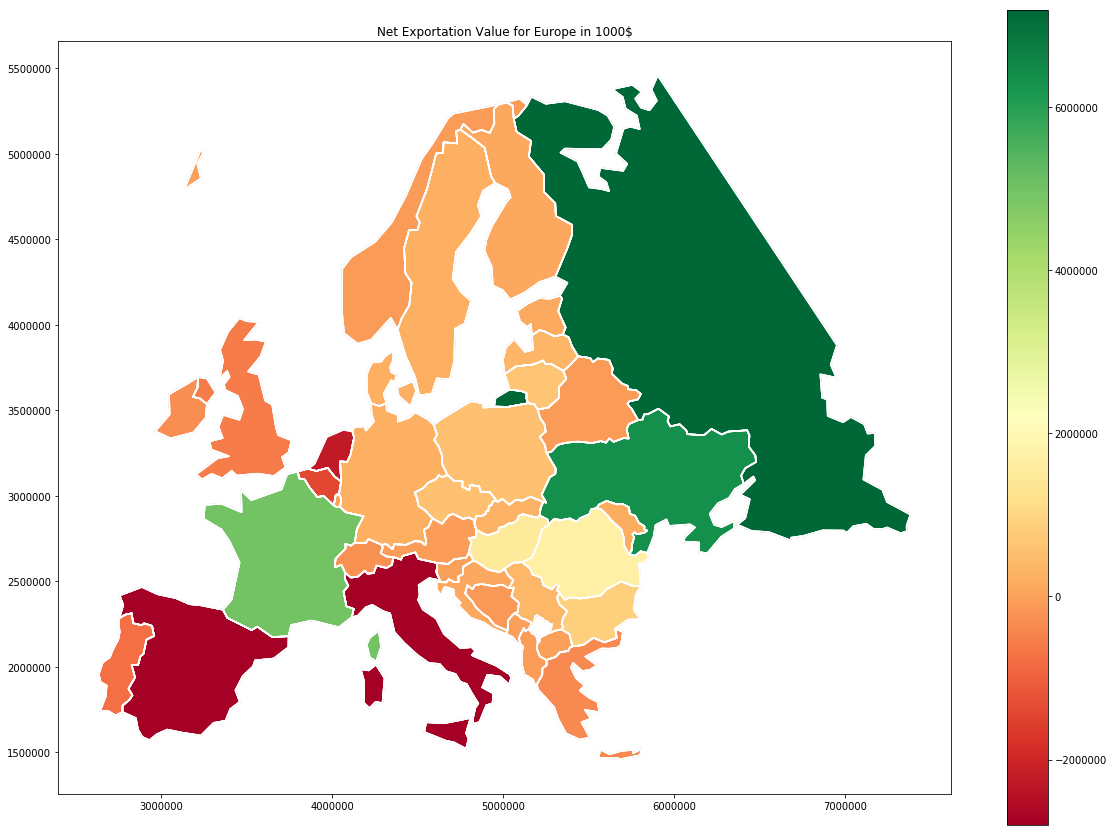

In [126]:
ax = europe.boundary.plot(color='white', edgecolor='black',figsize=(20,15))
europe.plot(ax = ax, edgecolor='black',column='profit',cmap='RdYlGn',legend=True);
ax.set_title('Net Exportation Value for Europe in 1000$')

Text(0.5, 1.0, 'Net Exportation Quantity for Europe in 1000$')

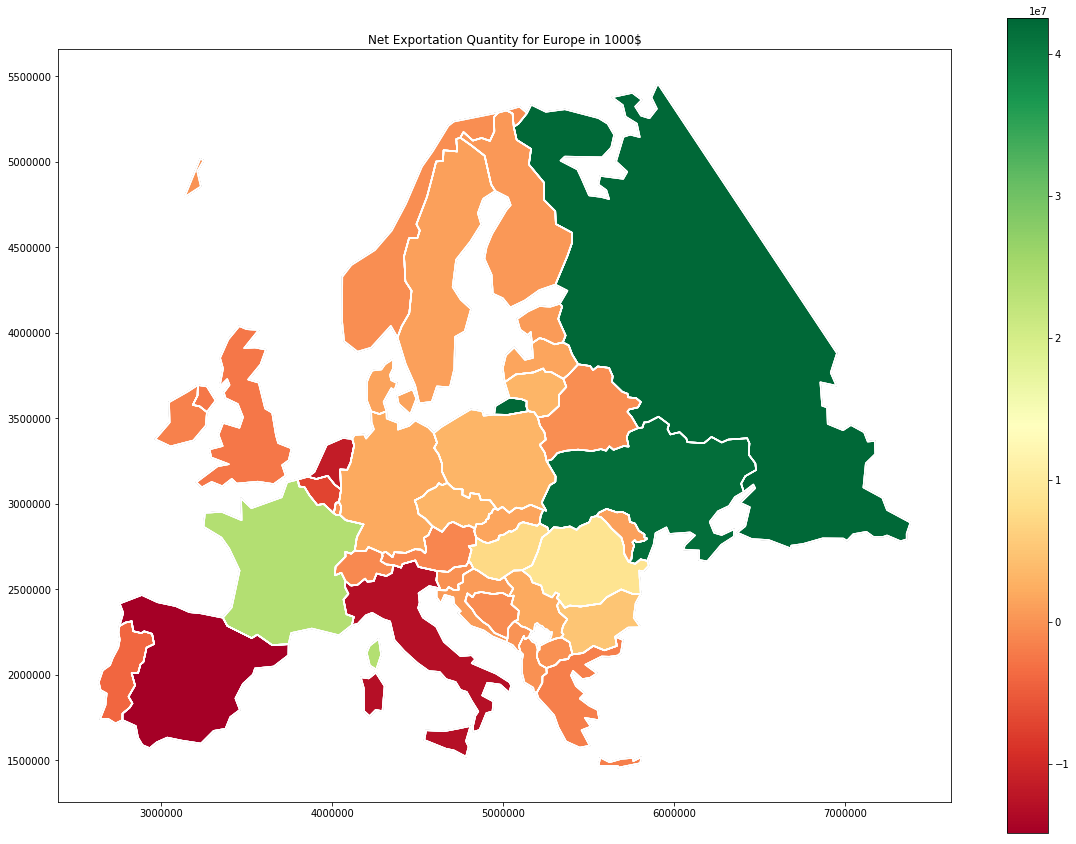

In [127]:
ax = europe.boundary.plot(color='white', edgecolor='black',figsize=(20,15))
europe.plot(ax = ax, edgecolor='black',column='diff_quantity',cmap='RdYlGn',legend=True);
ax.set_title('Net Exportation Quantity for Europe in 1000$')

<a id='plots3'></a>
### 7.C Third Example : Time Series for Net Exported quantity and profit in Europe

In [136]:
df_cereals_europe = df_cereals[df_cereals['area_code'].isin(dicts.get(5400))]
df_cereals_europe = df_cereals_europe.groupby('year')['export_quantity','export_value','import_quantity','import_value'].sum().reset_index()

df_cereals_europe['diff_quantity'] = df_cereals_europe['export_quantity'] - df_cereals_europe['import_quantity']
df_cereals_europe['profit'] = df_cereals_europe['export_value'] - df_cereals_europe['import_value']
df_cereals_europe.head()

,year,export_quantity,export_value,import_quantity,import_value,diff_quantity,profit
0,1961,14954780.0,893913.0,38892948.0,2459411.0,-23938168.0,-1565498.0
1,1962,13905441.0,944620.0,42223069.0,2734470.0,-28317628.0,-1789850.0
2,1963,15218486.0,1031295.0,43469386.0,2858280.0,-28250900.0,-1826985.0
3,1964,13783309.0,939085.0,48654611.0,3295668.0,-34871302.0,-2356583.0
4,1965,15698172.0,1063646.0,51880377.0,3495503.0,-36182205.0,-2431857.0


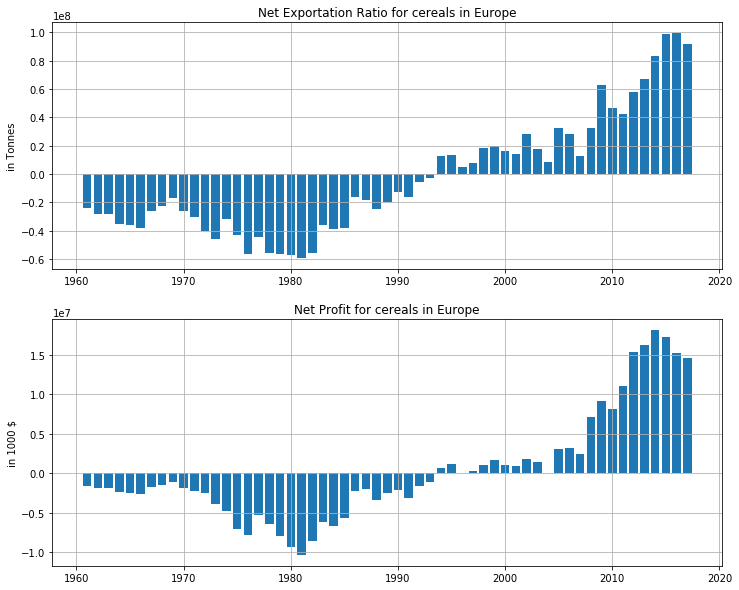

In [138]:
fig, ax = plt.subplots(2,1,figsize=(12,10))

ax[0].bar(df_cereals_europe.year,df_cereals_europe['diff_quantity'])
ax[0].set_title('Net Exportation Ratio for cereals in Europe')
ax[0].set_ylabel('in Tonnes')
ax[1].bar(df_cereals_europe.year,df_cereals_europe['profit'])
ax[1].set_title('Net Profit for cereals in Europe')
ax[1].set_ylabel('in 1000 $')
ax[0].grid()
ax[1].grid()

<a id='plots4'></a>
### 7.D Fourth Example : Most Exported Crop in Africa

In [139]:
df_import_export[df_import_export['area_code'].isin(dicts.get(list_group[0]))]

,area,item_x,year,area_code,unit,hs12_code,parent_group,child_group,export_quantity,export_value,import_quantity,import_value
32117,Algeria,Alfalfa meal and pellets,1968,4,tonnes,121410,12,1214,0.0,0.0,135.0,10.0
32118,Algeria,Alfalfa meal and pellets,1969,4,tonnes,121410,12,1214,0.0,0.0,680.0,50.0
32119,Algeria,Alfalfa meal and pellets,1970,4,tonnes,121410,12,1214,0.0,0.0,234.0,18.0
32120,Algeria,Alfalfa meal and pellets,1971,4,tonnes,121410,12,1214,0.0,0.0,46.0,4.0
32121,Algeria,Alfalfa meal and pellets,1972,4,tonnes,121410,12,1214,0.0,0.0,70.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2826393,Zimbabwe,"Yoghurt, concentrated or not",2013,181,tonnes,040310,4,403,4.0,11.0,719.0,1249.0
2826394,Zimbabwe,"Yoghurt, concentrated or not",2014,181,tonnes,040310,4,403,8.0,12.0,530.0,766.0
2826395,Zimbabwe,"Yoghurt, concentrated or not",2015,181,tonnes,040310,4,403,9.0,15.0,161.0,185.0
2826396,Zimbabwe,"Yoghurt, concentrated or not",2016,181,tonnes,040310,4,403,0.0,0.0,163.0,143.0


In [141]:
tmp = df_import_export[df_import_export['area_code'].isin(dicts.get(list_group[0]))]

In [142]:
tmp = tmp.groupby(['parent_group','year'])['export_quantity','export_value','import_quantity','import_value'].sum().reset_index()

In [143]:
tmp.head()

,parent_group,year,export_quantity,export_value,import_quantity,import_value
0,2,1961,62917.0,32350.0,77474.0,54378.0
1,2,1962,69634.0,35993.0,57502.0,41646.0
2,2,1963,70558.0,36412.0,54141.0,36392.0
3,2,1964,81398.0,44592.0,49032.0,32374.0
4,2,1965,89154.0,53385.0,50377.0,37715.0


In [144]:
tmp = tmp[tmp.year==2017]

In [145]:
tmp['diff_quantity'] = tmp['export_quantity'] - tmp['import_quantity']
tmp['profit'] = tmp['export_value'] - tmp['import_value']
tmp.head()

,parent_group,year,export_quantity,export_value,import_quantity,import_value,diff_quantity,profit
56,2,2017,208349.0,555056.0,3059471.0,4553724.0,-2851122.0,-3998668.0
113,4,2017,1029702.0,1953700.0,3377523.0,7652172.0,-2347821.0,-5698472.0
170,5,2017,0.0,1756005.0,0.0,795210.0,0.0,960795.0
227,7,2017,4980771.0,3887871.0,4312024.0,2780501.0,668747.0,1107370.0
284,8,2017,9364400.0,9892787.0,1602255.0,1568225.0,7762145.0,8324562.0


In [146]:
tmp.sort_values('diff_quantity',ascending=False)

,parent_group,year,export_quantity,export_value,import_quantity,import_value,diff_quantity,profit
284,8,2017,9364400.0,9892787.0,1602255.0,1568225.0,7762145.0,8324562.0
797,18,2017,3443503.0,8880991.0,212784.0,702242.0,3230719.0,8178749.0
1481,52,2017,1145031.0,1779002.0,232937.0,390276.0,912094.0,1388726.0
1253,40,2017,903614.0,1228274.0,72406.0,139201.0,831208.0,1089073.0
341,9,2017,1529575.0,5138002.0,844901.0,2225082.0,684674.0,2912920.0
227,7,2017,4980771.0,3887871.0,4312024.0,2780501.0,668747.0,1107370.0
1139,24,2017,580390.0,2848695.0,306173.0,2535171.0,274217.0,313524.0
1424,51,2017,75403.0,413123.0,15602.0,70199.0,59801.0,342924.0
1310,41,2017,65797.0,102037.0,27762.0,21730.0,38035.0,80307.0
1538,53,2017,34858.0,45747.0,23295.0,41982.0,11563.0,3765.0


Comments : "Fruit and nuts, edible; peel of citrus fruit or melons" that are the most exported and cereals that are the most imported

# 7.E Function super useful

In [155]:
dicts.get(5100)

array([  4,   7,  53,  20, 233,  29,  35,  32,  37,  39,  45,  46, 107,
       250,  72,  59,  61, 178, 209, 238,  62,  74,  75,  81,  90, 175,
       114, 122, 123, 124, 129, 130, 133, 136, 137, 143, 144, 147, 158,
       159, 184, 193, 195, 196, 197, 201, 202, 277, 276, 206, 217, 222,
       226, 215, 251, 181], dtype=int64)

In [393]:
def badassfunction(df_import_export,group_country=None,country=None,group_crops=None,crops=None,year=None,by_crop=False,by_country=False):
    """
    From the original dataset, this function will processed the dataset 
    to return a summary of the desired crops, country and year
    INPUTS : 
    - df_import_export
    - group_country
    - country
    - group_crops
    - year
    OUTPUT : 
    - cleaned df
    """
    df_cleaned = df_import_export
    # Extract country
    if group_country != None :
        df_cleaned = df_cleaned[df_cleaned['area_code'].isin(dicts.get(group_country))]
    if country != None:
        df_cleaned = df_cleaned[df_cleaned['country_code']==country]
    if group_crops != None:
        df_cleaned = df_cleaned[df_cleaned['parent_group']==group_crops]
    if crops != None:
        df_cleaned = df_cleaned[df_cleaned['child_group']==crops]
    if year != None: 
        df_cleaned = df_cleaned[df_cleaned['year']==year]
     
    # Add new features
    df_cleaned['diff_quantity'] = df_cleaned['export_quantity'] - df_cleaned['import_quantity']
    df_cleaned['profit'] = df_cleaned['export_value'] - df_cleaned['import_value']

    # If feature is added above then add it name in that list
    list_features = ['export_quantity','export_value','import_quantity','import_value','diff_quantity','profit']
    #Group by item
    if by_crop:
        df_sum = df_cleaned.groupby(['item_x','parent_group','child_group'])[list_features].sum().reset_index()

        df_max = df_cleaned.groupby(['item_x','parent_group','child_group'])[list_features].max().reset_index()   
        df_max_index = df_cleaned.groupby(['item_x','parent_group','child_group'])[list_features].idxmax().reset_index()

        df_min = df_cleaned.groupby(['item_x','parent_group','child_group'])[list_features].min().reset_index()
        df_min_index =  df_cleaned.groupby(['item_x','parent_group','child_group'])[list_features].idxmin().reset_index()
    
        merge_item = 'item_x'
        replace_item = 'area'

    if by_country:
        df_sum = df_cleaned.groupby(['area','area_code'])[list_features].sum().reset_index()

        df_max = df_cleaned.groupby(['area','area_code'])[list_features].max().reset_index()   
        df_max_index = df_cleaned.groupby(['area','area_code'])[list_features].idxmax().reset_index()

        df_min = df_cleaned.groupby(['area','area_code'])[list_features].min().reset_index()
        df_min_index =  df_cleaned.groupby(['area','area_code'])[list_features].idxmin().reset_index()
    
        merge_item = 'area'
        replace_item = 'item_x'
    
    for i in range(len(list_features)):
        df_max_index.loc[:,list_features[i]] = df_import_export.loc[df_max_index.loc[:,list_features[i]],replace_item].values
    for i in range(len(list_features)):
        df_min_index.loc[:,list_features[i]] = df_import_export.loc[df_min_index.loc[:,list_features[i]],replace_item].values
    
    # merge max 
    df_max_merged = pd.merge(df_max.loc[:,[merge_item]+list_features],df_max_index.loc[:,[merge_item]+list_features],left_on=merge_item,right_on=merge_item,how='inner',suffixes=('_max','_max_names'))
    # merge min 
    df_min_merged = pd.merge(df_min.loc[:,[merge_item]+list_features],df_min_index.loc[:,[merge_item]+list_features],left_on=merge_item,right_on=merge_item,how='inner',suffixes=('_min','_min_names'))

    # merge total
    df_merged_tot = pd.merge(df_min_merged,df_max_merged, left_on=merge_item,right_on=merge_item)
    
    df_tot = pd.merge(df_sum, df_merged_tot, left_on=merge_item,right_on=merge_item)
    return df_tot

In [394]:
df_tot = badassfunction(df_import_export,group_country=5400,country=None,group_crops=10,crops=None,year=2016,by_crop=True)

In [395]:
df_tot

,item_x,parent_group,child_group,export_quantity,export_value,import_quantity,import_value,diff_quantity,profit,export_quantity_min,...,import_quantity_max,import_value_max,diff_quantity_max,profit_max,export_quantity_max_names,export_value_max_names,import_quantity_max_names,import_value_max_names,diff_quantity_max_names,profit_max_names
0,Barley,10,1003,23892882.0,3978689.0,8924820.0,1649865.0,14968062.0,2328824.0,0.0,...,1858607.0,324416.0,5807291.0,1051145.0,France,France,Netherlands,Belgium,France,France
1,Buckwheat,10,1008,82816.0,43784.0,117058.0,62291.0,-34242.0,-18507.0,0.0,...,45445.0,12726.0,13527.0,6285.0,Latvia,Lithuania,Spain,Spain,Latvia,Russian Federation
2,Canary seed,10,1008,14744.0,9213.0,61462.0,42205.0,-46718.0,-32992.0,0.0,...,25284.0,15418.0,1901.0,1169.0,Belgium,Belgium,Belgium,Belgium,Hungary,Hungary
3,Fonio,10,1008,45.0,108.0,250.0,349.0,-205.0,-241.0,0.0,...,136.0,107.0,3.0,23.0,Netherlands,Belgium,France,France,Germany,Belgium
4,"Grain, mixed",10,1008,33693.0,21002.0,39318.0,27874.0,-5625.0,-6872.0,0.0,...,19959.0,10816.0,20952.0,3064.0,Belgium,Belgium,Greece,Belgium,Belgium,Belgium
5,Maize,10,1005,42112027.0,8466317.0,27832468.0,6740841.0,14279559.0,1725476.0,0.0,...,6019860.0,1216443.0,17243023.0,2537940.0,Ukraine,Ukraine,Spain,Spain,Ukraine,Ukraine
6,Millet,10,1008,201100.0,46492.0,129445.0,50998.0,71655.0,-4506.0,0.0,...,26856.0,10701.0,94473.0,15617.0,Ukraine,Ukraine,Germany,Germany,Ukraine,Ukraine
7,Oats,10,1004,1102698.0,246108.0,1021366.0,242067.0,81332.0,4041.0,0.0,...,475865.0,104396.0,296355.0,59377.0,Finland,Finland,Germany,Germany,Finland,Finland
8,Rye,10,1002,881024.0,163773.0,585649.0,120299.0,295375.0,43474.0,0.0,...,292426.0,52581.0,425442.0,62700.0,Poland,Poland,Germany,Germany,Poland,Poland
9,Sorghum,10,1007,271621.0,57438.0,240943.0,68682.0,30678.0,-11244.0,0.0,...,94738.0,17510.0,110292.0,22767.0,France,France,Spain,Spain,France,France


<a id='ccl'></a>
# 8. Conclusion and next steps

### What we have done so far : 
- Removed the nan values from the dataframea and merged the two dataframes (Trade and Trades 2017)
- Analysed each item in the trade dataframe and we mapped it to its core product in crops
- Prepare the dataframe to be grouped by country
- Prepare the dataframe to be grouped by crops category
- All the Elements (Type of value measured) were changed so for one Country, one crop and one specific year we can obtain the Import Value/Quantity, Export Value/Quantity, Production, Area Harvested and Yield on the same row. As you can see with that dataframe it’s really convenient to extract some information on countries, group of countries, crops or group of crops. We can easily compute for example the evolution for one group of crops over time in one region.
- First example on the “Cereals” category with Folium 

### Next steps : 
- Answer our research questions. Indeed, we first expressed the idea to look at the country which imported the most or exported the most and which type of crops was the most produced/traded. 
- We also want to analyze the supply chain of some categories of products at a global scale first and then dive in into specific regions and see the differences between countries or crops. Can we group them 
- We thought of using K-Means clustering method. Looking at the data, voir si des clusters apparaissent avec les crops, ou les trades et comparer aux clusters habituels : clusterings géographiques(continents, Nord/Sud) clustering social : (Pays en développement, pays développé)
- Evolution through years of certain crops and links to certain events or trends in particular. 
- Come up with some nice interactive visualization methods with Folium so the user can select one group of crops for one specific year and it appears automatically on the map with some characteristics for each country (for example most produced crop, most exported, most imported …) when the user click on it.


<a id='teaser'></a>
# 9. Teaser
We would like to use Folium to enable good geographic visualisations of importations and exportations of goods. It will rend the investigations of differents goods much easier. Below is a result of what we would do with cereals in 2017.

Note, a geojson is need for Folium. Json can be found ===> [here:](https://github.com/python-visualization/folium/blob/master/examples/data/world-countries.json) <====

Note: Notebook is fully and quickly runnable from here.

In [1]:
import folium
import json
import pandas as pd
import geopandas

In [397]:
df_cereals_2017 = pd.read_pickle("./df_cereals_2017.pkl")

In [398]:
def show_production_countries(df, profit=True, filename='data/countries_profit.html'):
    """
    Complete function that takes some predefined df and output a map of the requested food for a given year.
    Show a folium map and then save the plot in an html file
    """
    look_word = 'profit' if profit else 'diff_quantity'
    min_profit = df[look_word].min()
    max_profit = df[look_word].max()

    countries = geopandas.read_file('data/world-countries.json')
    cm = countries.merge(df, left_on='name', right_on='area')
    cm[look_word] = cm[look_word].apply(lambda value : f'{int(value):,}')
    val_or_q = 'value' if profit else 'quantity'
    cm['export_' + val_or_q] = cm['export_' + val_or_q].apply(lambda value : f'{int(value):,}')
    cm['Import ' + val_or_q] = cm['import_' + val_or_q].apply(lambda value : f'{int(value):,}')
    cm.to_file("data/countries-production.json", driver='GeoJSON')
    geo_json_data = json.load(open('data/countries-production.json'))

    def my_color_function(feature):
        """Maps high values to green and negative values to red."""
        if len(df[df['area'] == feature['properties']['name']][look_word]) == 0:
            return '#ffffff'
        value = df[df['area'] == feature['properties']['name']][look_word].iloc[0]
        if value > 0:
            green = hex(127 + int((value / max_profit) * 255 / 2 ))[-2:]
            return '#00' + green + '00'
        else:
            red = hex(int(127 + (value / min_profit) * 255 / 2 ))[-2:]
            return '#' + red + '00' + '00'

    def my_highlight_function(feature):
        return {
            'fillColor': 'black',
            'color' : 'black',
            'weight' : 3,
            'dashArray' : '5, 5'
            }


    m = folium.Map([150,-200], zoom_start=2)

    folium.GeoJson(
        geo_json_data,
        style_function=lambda feature: {
            'fillColor': my_color_function(feature),
            'color' : 'black',
            'weight' : 1.5,
            'dashArray' : '5, 5'
            },
        highlight_function=my_highlight_function,
        tooltip=folium.features.GeoJsonTooltip(
            fields=['name', look_word, 'export_' + val_or_q, 'import_' + val_or_q],
            aliases=['State name:', look_word + ':', 'Export ' + val_or_q + ":", 'Import ' + val_or_q + ":"],
        )
        ).add_to(m)
    m.save(filename)
    return m
        

In case Folium doesn't render well on unrunned notebook, we strongly encourage you to check out directly our generated html files `Countries_Cereals_2017_Quantity.html` and `Countries_Cereals_2017_Profit.html`. Ottherwise, enjoy the following cells.

In [399]:
show_production_countries(df_cereals_2017, False, './Countries_Cereals_2017_Quantity.html')

DriverError: data/world-countries.json: No such file or directory

In [400]:
show_production_countries(df_cereals_2017, True, './Countries_Cereals_2017_Profit.html')

DriverError: data/world-countries.json: No such file or directory